In [1]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle competitions download -c state-farm-distracted-driver-detection

100% 3.98G/4.00G [00:23<00:00, 236MB/s]
100% 4.00G/4.00G [00:23<00:00, 182MB/s]


In [5]:
! unzip /content/state-farm-distracted-driver-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

# Import Libraries

In [6]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
from tensorflow.keras import layers
from keras import models 
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint

#VIS
from keras.utils.vis_utils import plot_model

#Preprocessing Data

In [7]:
def preparData(path):
  imagsList = []
  labels = []
  for dic in sorted(glob.glob(os.path.join(path,'*')), key = lambda k: k.split('/')[-1]):
    for imgs in glob.glob(os.path.join(dic, '*.jpg')):
      img = cv2.imread(imgs)
      img_r = cv2.resize(img,(128,128))
      imagsList.append(img_r)
      labels.append(int(dic.split("/")[-1].replace('c','')))
  
  X_train, X_test, y_train, y_test = train_test_split(imagsList, labels, test_size=0.2,shuffle= True, random_state = 0)
  y_train = to_categorical(y_train)
  y_test  = to_categorical(y_test)

  return np.array(X_train), np.array(X_test), y_train, y_test


#Get Data

In [8]:
path_train = "/content/imgs/train/"
path_test  = "/content/imgs/test/"

X_train, X_test, y_train, y_test = preparData(path_train)

print(f"Size X_train: {len(X_train)}, Size y_train: {len(y_train)}")
print(f"Size X_test: {len(X_test)}, Size y_test {len(y_test)}")

Size X_train: 17939, Size y_train: 17939
Size X_test: 4485, Size y_test 4485


# ConvNet Model

In [9]:
conv_model = models.Sequential()

conv_model.add(layers.InputLayer(input_shape=(128, 128, 3)))

conv_model.add(layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', name='Conv_1'))

conv_model.add(layers.MaxPool2D(pool_size = (2,2), name = 'Pool_1'))

conv_model.add(layers.Conv2D(filters = 64,kernel_size = (5,5),activation = 'relu',name = 'Conv_2'))

conv_model.add(layers.MaxPool2D(pool_size = (2,2),name = 'Pool_2'))

conv_model.add(layers.Conv2D(filters = 128,kernel_size = (5,5),activation = 'relu',name = 'Conv_3'))

conv_model.add(layers.MaxPool2D(pool_size = (2,2),name = 'Pool_3'))

conv_model.add(layers.Conv2D(filters = 256,kernel_size = (5,5),activation = 'relu',name = 'Conv_4'))

conv_model.add(layers.MaxPool2D(pool_size = (2,2),name = 'Pool_4'))

conv_model.add(layers.Flatten())
conv_model.add(layers.Dense(units=1024, activation='relu',name = 'fc_1'))
conv_model.add(layers.Dropout(rate=0.2))
conv_model.add(layers.Dense(units=512, activation='relu',name = 'fc_2'))
conv_model.add(layers.Dense(units=10,activation='softmax',name = 'fc_3'))


In [10]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 Pool_1 (MaxPooling2D)       (None, 62, 62, 32)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 58, 58, 64)        51264     
                                                                 
 Pool_2 (MaxPooling2D)       (None, 29, 29, 64)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 25, 25, 128)       204928    
                                                                 
 Pool_3 (MaxPooling2D)       (None, 12, 12, 128)       0         
                                                                 
 Conv_4 (Conv2D)             (None, 8, 8, 256)         8

**Plot Model**

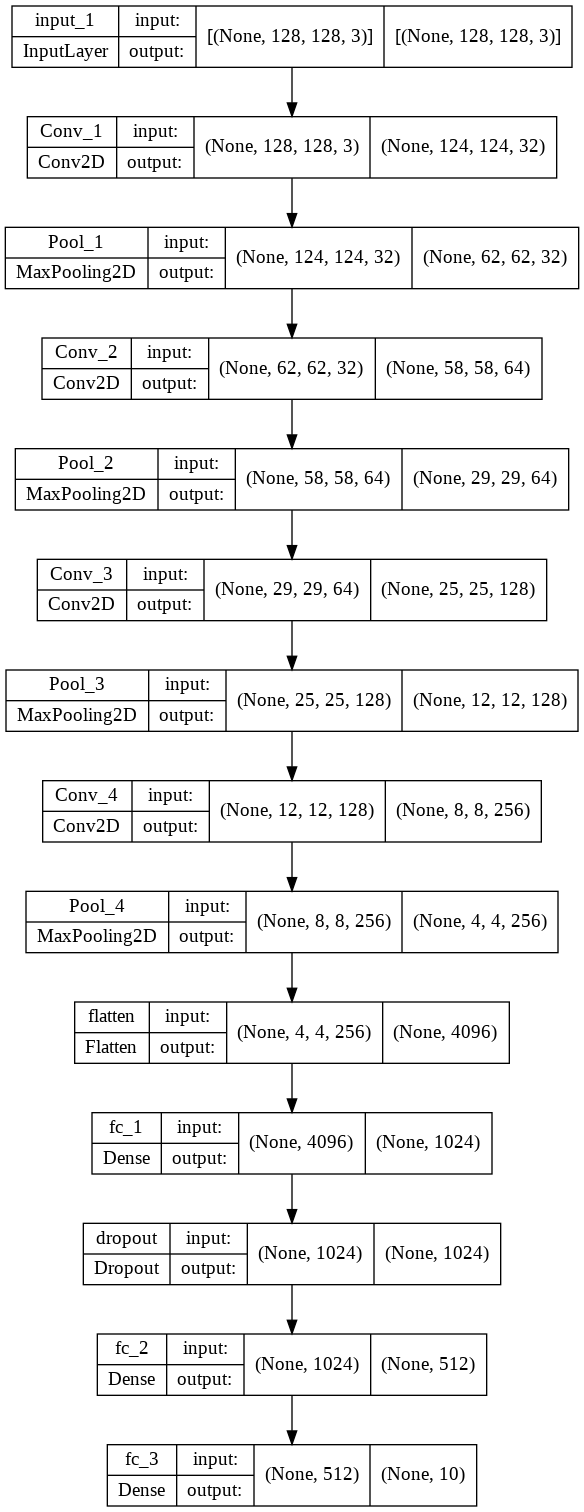

In [11]:
plot_model(conv_model,show_shapes=True)

**Model Compile**

In [12]:
conv_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

**Train Model**

In [13]:
conv_history = conv_model.fit(X_train, y_train, epochs = 10, batch_size = 512, validation_split = 0.2)

Epoch 1/10
29/29 [==============================] - 25s 347ms/step - loss: 7.9487 - accuracy: 0.2179 - val_loss: 1.7574 - val_accuracy: 0.3626
Epoch 2/10
29/29 [==============================] - 9s 323ms/step - loss: 1.2319 - accuracy: 0.5789 - val_loss: 1.1136 - val_accuracy: 0.6012
Epoch 3/10
29/29 [==============================] - 9s 323ms/step - loss: 0.5911 - accuracy: 0.8098 - val_loss: 0.3653 - val_accuracy: 0.8868
Epoch 4/10
29/29 [==============================] - 9s 325ms/step - loss: 0.2817 - accuracy: 0.9135 - val_loss: 0.2396 - val_accuracy: 0.9242
Epoch 5/10
29/29 [==============================] - 9s 326ms/step - loss: 0.2164 - accuracy: 0.9376 - val_loss: 0.1406 - val_accuracy: 0.9632
Epoch 6/10
29/29 [==============================] - 9s 327ms/step - loss: 0.1141 - accuracy: 0.9676 - val_loss: 0.1259 - val_accuracy: 0.9635
Epoch 7/10
29/29 [==============================] - 10s 328ms/step - loss: 0.0745 - accuracy: 0.9787 - val_loss: 0.1221 - val_accuracy: 0.9691
Epoc

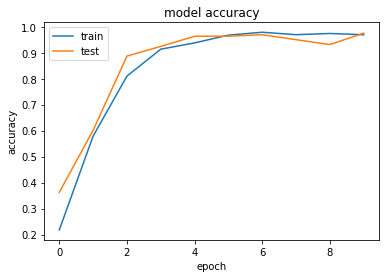

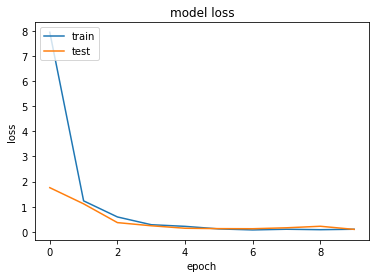

In [14]:
plt.plot(conv_history.history['accuracy'])
plt.plot(conv_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(conv_history.history['loss'])
plt.plot(conv_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Save Model

In [15]:
conv_model.save('ConvNet_model.h5')